# **SIT 215 - Project**

# **Investigating Reinforcement Learning**

## Cartpole - Q-Learning Agent

### Mir Muhammad Sohaib 
### 220576368

# 1. Dependencies

## 1.1. Installing dependencies

In [1]:
# For using Open AI Gym
!pip install gym 

# For visualising Open AI Gym
!pip install pygame     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.9 MB/s 


## 1.2. Importing relevant libraries

In [2]:
# Importing relevant libraries 
import gym 
from random import random, uniform 
import math  
import numpy as np                                 
from random import random 
import matplotlib                          
import matplotlib.pyplot as plt

# 2. Q-Learning Agent

In [3]:
# Cartpole bucket hyperparameters
CARTPOLE_POSITION_BUCKETS = 2
CARTPOLE_POSITION_RANGE = (-2.0, 2.0)
CARTPOLE_VELOCITY_BUCKETS = 8
CARTPOLE_VELOCITY_RANGE = (-1.2, 1.2)
CARTPOLE_THETA_BUCKETS = 16
CARTPOLE_THETA_RANGE = (-0.08, 0.08)
CARTPOLE_THETA_VELOCITY_BUCKETS = 6
CARTPOLE_THETA_VELOCITY_RANGE = (-1.2, 1.2)

# Q-Learning Agent
class Qlearner():
    def __init__(self, parameters):
        self.alpha = parameters['alpha']
        self.gamma = parameters['gamma']
        self.epsilon = parameters['epsilon']
        super().__init__()

    def initialize_cartpole_q_table(self, env):
        obs_space = CARTPOLE_POSITION_BUCKETS * CARTPOLE_VELOCITY_BUCKETS * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        self.q_table = np.zeros([obs_space, env.action_space.n])

        # Establish weak priors to optimise training - if theta < 0, move left, if theta > 0 move right
        for i in range(obs_space):
            if (i % (CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS) < (CARTPOLE_THETA_BUCKETS / 2)):
                self.q_table[i][0] = 0.1
            elif (i % (CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS) >= (CARTPOLE_THETA_BUCKETS / 2)):
                self.q_table[i][1] = 0.1

    def cartpole_training_action(self, env, observation):
        self.previous_observation = observation
        if random() < self.epsilon:
            # Explore
            return env.action_space.sample() 
        else:
            # Exploit
            return np.argmax(self.q_table[self._cartpole_obs_index(observation)]) 

    def cartpole_evaluation_action(self, observation):
        return np.argmax(self.q_table[self._cartpole_obs_index(observation)])

    def cartpole_update(self, observation, action, reward):
        # Updates the previous observation qtable entry with the reward gained, uses the maximum/best future option always
        old_value = self.q_table[self._cartpole_obs_index(self.previous_observation), action]
        next_max = np.max(self.q_table[self._cartpole_obs_index(observation)])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[self._cartpole_obs_index(self.previous_observation), action] = new_value

    def _cartpole_obs_index(self, observation):
        # Since cartpole observations are continuous, we have to bucket them and calculate an index for the qtable
        position, velocity, theta, theta_velocity = observation

        bucketed_position = self._bucket(position, CARTPOLE_POSITION_BUCKETS, CARTPOLE_POSITION_RANGE)
        bucketed_velocity = self._bucket(velocity, CARTPOLE_VELOCITY_BUCKETS, CARTPOLE_VELOCITY_RANGE)
        bucketed_theta = self._bucket(theta, CARTPOLE_THETA_BUCKETS, CARTPOLE_THETA_RANGE)
        bucketed_theta_velocity = self._bucket(theta_velocity, CARTPOLE_THETA_VELOCITY_BUCKETS, CARTPOLE_THETA_VELOCITY_RANGE)

        position_index = (bucketed_position - 1) * CARTPOLE_VELOCITY_BUCKETS * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        velocity_index = (bucketed_velocity - 1) * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        theta_index = (bucketed_theta - 1) * CARTPOLE_THETA_VELOCITY_BUCKETS
        theta_velocity_index = (bucketed_theta_velocity - 1)

        index = position_index + velocity_index + theta_index + theta_velocity_index
        return index

    def _bucket(self, observation, num_buckets, obs_range):
        # Calculate bucket number
        r_min = obs_range[0]
        r_max = obs_range[1]
        r_range = r_max - r_min
        bucket_size = r_range / num_buckets
        bucket = math.ceil((observation + r_range / 2) / bucket_size)

        # Bound
        bucket = min(bucket, num_buckets)
        bucket = max(bucket, 1)
        return bucket

# 3. Driver Class (Helper Methods)

In [4]:
class Driver:
    # Initialise
    def __init__(self, params):
        self.epochs = params['epochs']
        self.env = params['env']
        self.agent = params['agent']
        self.training_rewards = []
        self.evaluation_rewards = []

    # Run Q-Learning
    def run_cartpole_qlearner(self):
        self.agent.initialize_cartpole_q_table(self.env)

        training_action = lambda observation: self.agent.cartpole_training_action(self.env, observation)
        update = lambda observation, action, reward: self.agent.cartpole_update(observation, action, reward)
        evaluation_action = lambda observation: self.agent.cartpole_evaluation_action(observation)

        self.run(training_action, update, evaluation_action)
        
    # Training and evaluation loop, plots then demonstrate
    def run(self, training_action, update, evaluation_action):
        for i in range(self.epochs):
            if ((i + 1) % 1000 == 0):
                print("Progress: {}%".format(100 * (i + 1) // self.epochs))
            self.train_once(training_action, update)
            self.evaluate_once(evaluation_action)

        self.plot()

    # A single instance of training of the agent in the environment
    def train_once(self, training_action, update):
        observation = self.env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = training_action(observation)
            observation, reward, done, info = self.env.step(action)
            episode_reward += reward
            update(observation, action, reward)
        self.training_rewards.append(episode_reward)

    # A single instance of evaluation of the agent at it's current level of training
    def evaluate_once(self, evaluation_action):
        observation = self.env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = evaluation_action(observation)
            observation, reward, done, info = self.env.step(action)
            episode_reward += reward
        self.evaluation_rewards.append(episode_reward)

    # Plot the training and evaluation reward levels at each epoch
    def plot(self):
        plt.subplot('211')
        plt.plot(self.training_rewards, linewidth=1)
        plt.title('Training reward over time')
        plt.ylabel('Reward')
        plt.xlabel('Iterations')

        plt.subplot('212')
        plt.plot(self.evaluation_rewards, linewidth=1)
        plt.title('Evaluation reward over time')
        plt.ylabel('Reward')
        plt.xlabel('Iterations')
        plt.tight_layout()
        plt.show()

# 4. Results

Progress: 2%
Progress: 4%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 22%
Progress: 24%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 42%
Progress: 44%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 62%
Progress: 64%
Progress: 66%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 84%
Progress: 86%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%


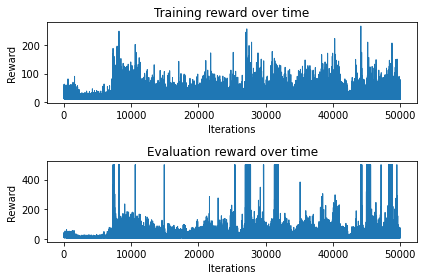

In [5]:
# Providing parameter values to the agent and driver
def cartpole_qlearner():
    agent = Qlearner({
        'alpha': 0.2,
        'gamma': 0.5,
        'epsilon': 0.1,
    })
    driver = Driver({
        'epochs': 50000,
        'env': gym.make('CartPole-v1'),
        'agent': agent,
    })
    driver.run_cartpole_qlearner()


if __name__ == '__main__':
    cartpole_qlearner()